In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import os
from PIL import Image

In [10]:
# image_dir =r"D:\Deep_Learning_BITS\train_data" 
# label_file = r"D:\Deep_Learning_BITS\train_data"
# for i in os.listdir(image_dir):
#     if int(i.split("_")[0]) < 10:
#         os.rename(image_dir + "/" + i, image_dir+"/0"+i)

# image_dir =r"D:\Deep_Learning_BITS\val_data" 
# label_file = r"D:\Deep_Learning_BITS\val_data" 
# for i in os.listdir(image_dir):
#     if int(i.split("_")[0]) < 10:
#         os.rename(image_dir + "/" + i, image_dir+"/0"+i)

In [11]:
class FlowerDataset(torch.utils.data.Dataset):
    def __init__(self, image_dir, label_file, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.image_filenames = [f for f in sorted(os.listdir(image_dir)) if f.endswith('.jpg')]
        self.labels = self.load_labels(label_file)

        assert len(self.image_filenames) == len(self.labels), "Mismatch between images and labels"

    def load_labels(self, label_file):
        with open(label_file, 'r') as f:
            labels = [int(line.strip()) - 1 for line in f]  # Adjust labels to start at 0
        return labels

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_filenames[idx])
        label = self.labels[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

In [12]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [13]:
train_dataset = FlowerDataset(image_dir=r"D:\Deep_Learning_BITS\train_data", label_file=r'D:\Deep_Learning_BITS\train_labels.txt', transform=transform)
val_dataset = FlowerDataset(image_dir=r"D:\Deep_Learning_BITS\val_data", label_file=r'D:\Deep_Learning_BITS\val_labels.txt', transform=transform)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=0)

In [14]:
model = models.resnet18(weights="ResNet18_Weights.DEFAULT")
num_classes = 60

# Replace the fully connected layer
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)

In [15]:
def train_and_validate(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    train_losses, train_accuracies, val_accuracies = [], [], []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct_train, total_train = 0, 0

        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct_train / total_train
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Validation phase
        model.eval()
        correct_val, total_val = 0, 0

        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc="Validating"):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_accuracy = 100 * correct_val / total_val
        val_accuracies.append(val_accuracy)

        print(f"Epoch [{epoch+1}/{num_epochs}] - "
              f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
              f"Val Accuracy: {val_accuracy:.2f}%")

    return train_losses, train_accuracies, val_accuracies

In [16]:
num_epochs = 10
train_losses, train_accuracies, val_accuracies = train_and_validate(
    model, train_loader, val_loader, criterion, optimizer, num_epochs
)

Validating: 100%|██████████| 38/38 [00:03<00:00, 11.48it/s]


Epoch [1/10] - Train Loss: 3.8019, Train Accuracy: 11.93%, Val Accuracy: 34.33%


Validating: 100%|██████████| 38/38 [00:02<00:00, 18.12it/s]


Epoch [2/10] - Train Loss: 2.8024, Train Accuracy: 52.63%, Val Accuracy: 65.17%


Validating: 100%|██████████| 38/38 [00:02<00:00, 18.02it/s]


Epoch [3/10] - Train Loss: 2.0815, Train Accuracy: 74.90%, Val Accuracy: 76.83%


Validating: 100%|██████████| 38/38 [00:02<00:00, 18.01it/s]


Epoch [4/10] - Train Loss: 1.5749, Train Accuracy: 86.83%, Val Accuracy: 85.83%


Validating: 100%|██████████| 38/38 [00:02<00:00, 16.98it/s]


Epoch [5/10] - Train Loss: 1.2169, Train Accuracy: 92.30%, Val Accuracy: 89.50%


Validating: 100%|██████████| 38/38 [00:02<00:00, 17.58it/s]


Epoch [6/10] - Train Loss: 0.9420, Train Accuracy: 95.03%, Val Accuracy: 90.83%


Validating: 100%|██████████| 38/38 [00:02<00:00, 18.08it/s]


Epoch [7/10] - Train Loss: 0.7441, Train Accuracy: 96.93%, Val Accuracy: 92.17%


Validating: 100%|██████████| 38/38 [00:02<00:00, 18.09it/s]


Epoch [8/10] - Train Loss: 0.5970, Train Accuracy: 97.77%, Val Accuracy: 93.50%


Validating: 100%|██████████| 38/38 [00:02<00:00, 18.15it/s]


Epoch [9/10] - Train Loss: 0.4635, Train Accuracy: 98.80%, Val Accuracy: 94.33%


Validating: 100%|██████████| 38/38 [00:02<00:00, 18.20it/s]

Epoch [10/10] - Train Loss: 0.3699, Train Accuracy: 99.17%, Val Accuracy: 94.00%


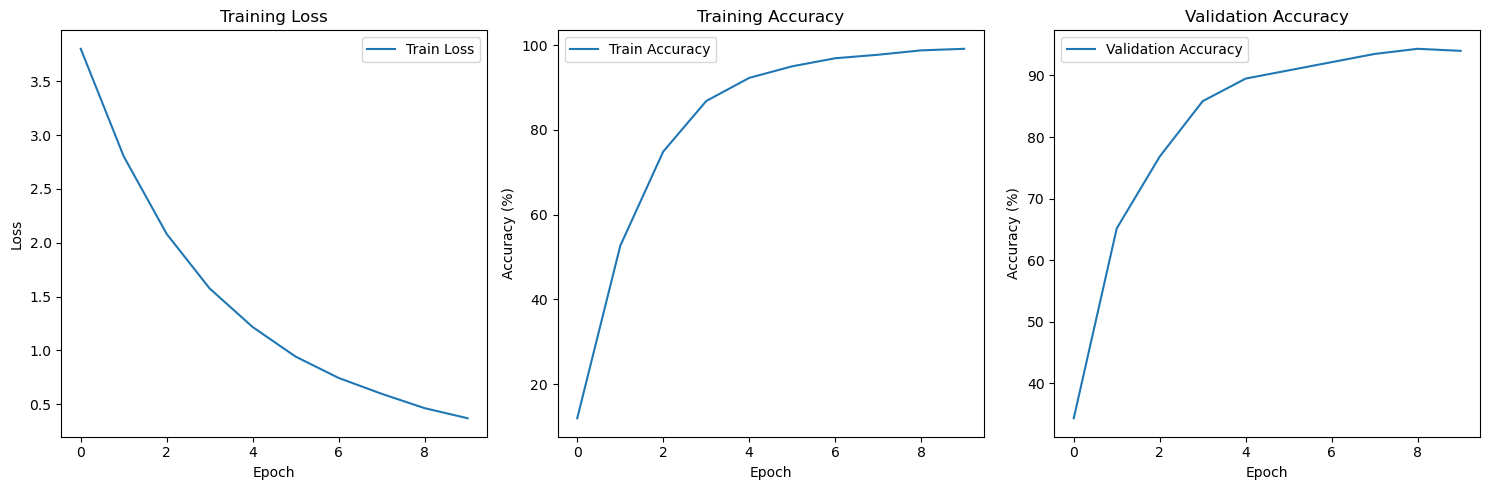

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [18]:
test_img_path = r"D:\Deep_Learning_BITS\val_data\12_image_04378.jpg"#Enter the absolute image file path to test
test_image = Image.open(test_img_path).convert("RGB")
test_image = transform(test_image).unsqueeze(0)

model.eval()
with torch.no_grad():
    output = model(test_image.to(device))
    _, predicted = torch.max(output, 1)

print(f"The predicted class for the image is: {predicted.item() + 1}")



The predicted class for the image is: 12


In [20]:
model_weights = model.state_dict()
model_weights

OrderedDict([('conv1.weight',
              tensor([[[[-1.0746e-02, -6.6067e-03, -2.2992e-03,  ...,  5.6227e-02,
                          1.6839e-02, -1.2850e-02],
                        [ 1.0709e-02,  9.0942e-03, -1.1039e-01,  ..., -2.7158e-01,
                         -1.2927e-01,  3.5544e-03],
                        [-7.3852e-03,  5.8612e-02,  2.9499e-01,  ...,  5.1927e-01,
                          2.5603e-01,  6.3322e-02],
                        ...,
                        [-2.7825e-02,  1.5683e-02,  7.2192e-02,  ..., -3.3344e-01,
                         -4.2102e-01, -2.5818e-01],
                        [ 3.0360e-02,  4.0777e-02,  6.2637e-02,  ...,  4.1332e-01,
                          3.9321e-01,  1.6576e-01],
                        [-1.4052e-02, -3.8153e-03, -2.4209e-02,  ..., -1.5113e-01,
                         -8.2507e-02, -5.9691e-03]],
              
                       [[-1.1295e-02, -2.6667e-02, -3.4680e-02,  ...,  3.2541e-02,
                          7.9192

In [21]:
model_save_path = 'resnet18_flower_classification.pth'
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to resnet18_flower_classification.pth
